In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

# Cấu hình hiển thị cho Jupyter Notebook
%matplotlib inline

# =========================================
# 1. CẤU HÌNH
# =========================================
INPUT_DIR = "../data_clear"
OUTPUT_DIR = "../data_clear2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_FILE = os.path.join(INPUT_DIR, "merged_filtered_processed.csv")

NULL_THRESHOLD = 0.5
CORR_THRESHOLD = 0.75
CHUNK_SIZE = 50000  # Đọc 50k dòng mỗi lần
SAMPLE_SIZE = 100000 # Kích thước mẫu để học quy tắc

In [2]:
# =========================================
# 2. CÁC HÀM HỌC QUY TẮC (TRÊN MẪU)
# =========================================
def get_cols_to_drop_null(path, threshold):
    """Xác định cột Null > threshold trên mẫu dữ liệu."""
    print(f"⏳ [Học Quy Tắc] Đang quét tỷ lệ Null từ mẫu {SAMPLE_SIZE} dòng...")
    df_sample = pd.read_csv(path, nrows=SAMPLE_SIZE)
    null_rates = df_sample.isnull().mean()
    cols = null_rates[null_rates > threshold].index.tolist()
    mandatory = ['TransactionID', 'isFraud', 'TransactionDT', 'card1']
    
    del df_sample
    gc.collect()
    return [c for c in cols if c not in mandatory]

def plot_and_get_corr_drops(path, threshold, cols_to_exclude=[]):
    """Vẽ Heatmap và xác định cột tương quan cao trên mẫu."""
    print(f"⏳ [Học Quy Tắc] Đang tính tương quan và vẽ biểu đồ từ mẫu...")
    # Đọc mẫu nhỏ hơn một chút để vẽ cho nhanh
    df_sample = pd.read_csv(path, nrows=50000)
    df_sample.drop(columns=cols_to_exclude, inplace=True, errors='ignore')
    
    # Chỉ lấy cột số
    df_numeric = df_sample.select_dtypes(include=np.number)
    if df_numeric.empty: return []

    # Chia nhóm để vẽ Heatmap cho dễ nhìn (C, D, M, V)
    all_cols = df_numeric.columns.tolist()
    groups = {
        'C': [c for c in all_cols if c.startswith('C')],
        'D': [c for c in all_cols if c.startswith('D')],
        'M': [c for c in all_cols if c.startswith('M')],
        'V': [c for c in all_cols if c.startswith('V')]
    }

    all_drop_corr = []
    for name, cols in groups.items():
        if len(cols) > 1:
            print(f"   -> Đang xử lý nhóm {name}...")
            # Tính ma trận tương quan cho nhóm
            corr_matrix = df_numeric[cols].corr().abs()
            
            # --- VẼ HEATMAP ---
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
            plt.title(f'Correlation Matrix - Group {name} (Sample)', fontsize=14)
            plt.tight_layout()
            plt.show() # Hiển thị ngay trong notebook
            # ------------------

            # Xác định cột cần loại bỏ
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
            all_drop_corr.extend(to_drop)

    del df_sample, df_numeric
    gc.collect()
    return list(set(all_drop_corr))

def get_medians(path, cols_to_exclude=[]):
    """Tính median trên mẫu."""
    print(f"⏳ [Học Quy Tắc] Đang tính Medians từ mẫu...")
    df_sample = pd.read_csv(path, nrows=SAMPLE_SIZE)
    df_sample.drop(columns=cols_to_exclude, inplace=True, errors='ignore')
    numeric_cols = df_sample.select_dtypes(include=np.number).columns
    
    medians = df_sample[numeric_cols].median().to_dict()
    del df_sample
    gc.collect()
    return medians

In [3]:
# =========================================
# 3. HÀM THỰC THI (ÁP DỤNG VÀ LƯU)
# =========================================
def process_and_save_chunked(input_path, output_path, drop_cols, medians):
    """Đọc, xóa cột, điền NaN và lưu từng phần."""
    print(f"🚀 Đang xử lý và lưu {os.path.basename(input_path)}...")
    
    first_chunk = True
    # Đọc file theo từng miếng (chunk)
    for i, chunk in enumerate(pd.read_csv(input_path, chunksize=CHUNK_SIZE)):
        print(f"   - Đang xử lý chunk {i+1}...", end='\r')
        
        # --- THỰC HIỆN XÓA CỘT TẠI ĐÂY ---
        chunk.drop(columns=drop_cols, inplace=True, errors='ignore')
        
        # --- THỰC HIỆN ĐIỀN NAN TẠI ĐÂY ---
        num_cols = [c for c in chunk.columns if c in medians]
        cat_cols = [c for c in chunk.columns if c not in medians and c != 'isFraud']
        chunk[num_cols] = chunk[num_cols].fillna(value=medians)
        for col in cat_cols: chunk[col] = chunk[col].fillna('Missing')

        # Lưu nối tiếp vào file
        mode = 'w' if first_chunk else 'a'
        header = first_chunk
        chunk.to_csv(output_path, index=False, mode=mode, header=header)
        first_chunk = False
        
        del chunk
        gc.collect()
    print(f"\n✅ Đã hoàn tất lưu file: {output_path}\n")

🔄 BẮT ĐẦU QUY TRÌNH 2 GIAI ĐOẠN

📊 --- GIAI ĐOẠN 1: HỌC QUY TẮC TỪ TẬP TRAIN ---
⏳ [Học Quy Tắc] Đang quét tỷ lệ Null từ mẫu 100000 dòng...
   => Tìm thấy 1 cột Null > 90.0%.
⏳ [Học Quy Tắc] Đang tính tương quan và vẽ biểu đồ từ mẫu...
   -> Đang xử lý nhóm C...


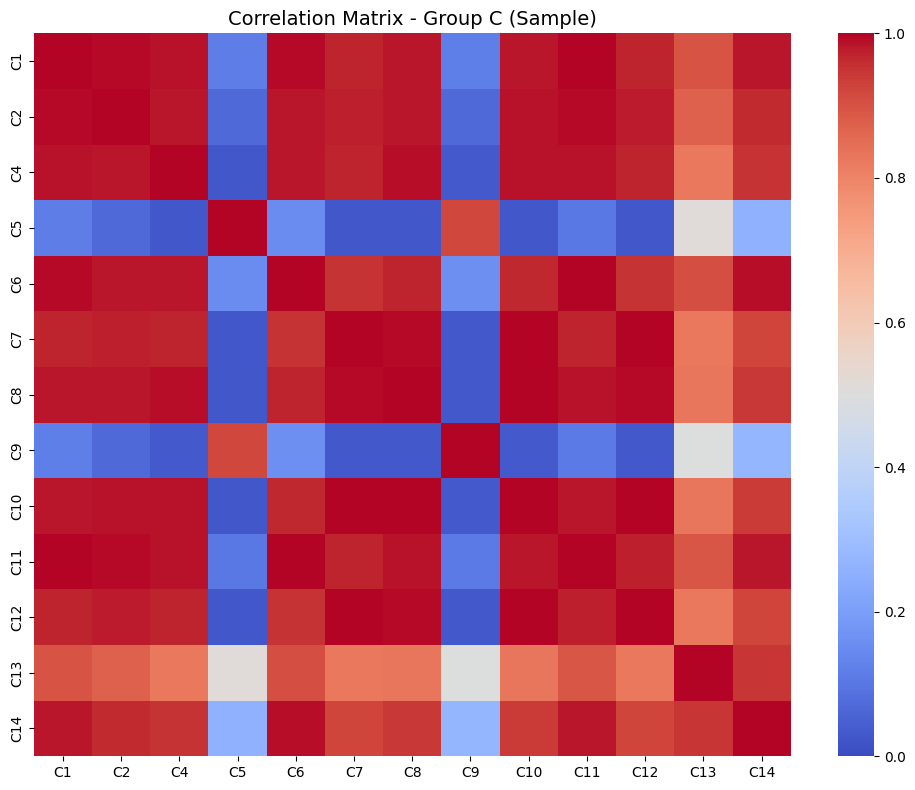

   -> Đang xử lý nhóm D...


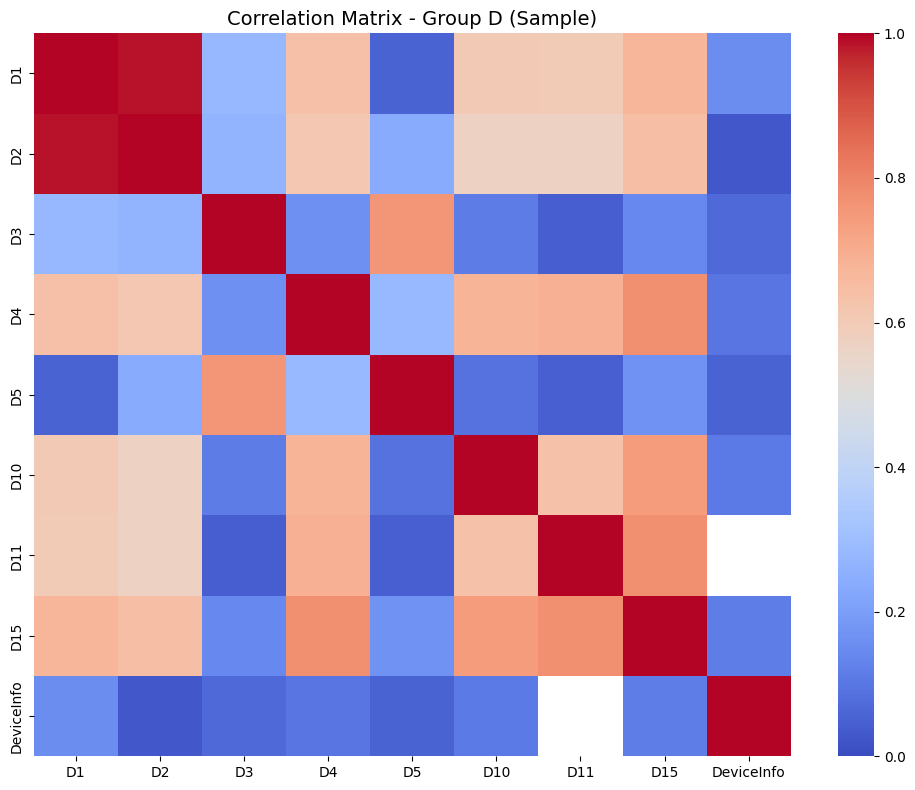

   -> Đang xử lý nhóm V...


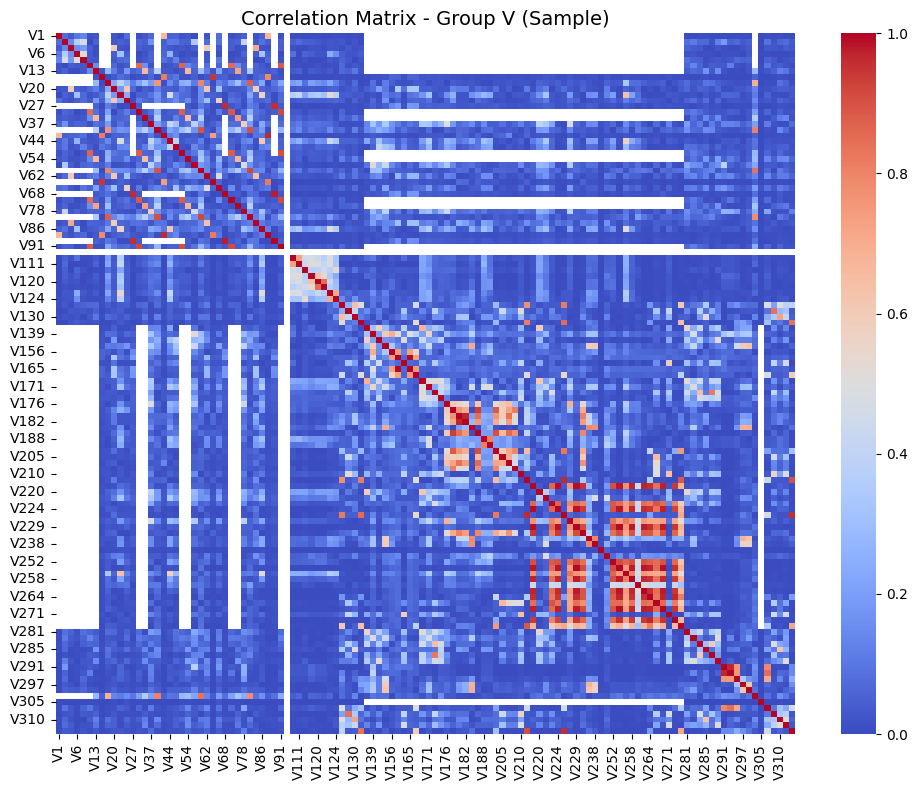

   => Tìm thấy 61 cột tương quan cao > 0.75.
🔥 TỔNG CỘNG CẦN XÓA: 62 CỘT.
⏳ [Học Quy Tắc] Đang tính Medians từ mẫu...

💾 --- GIAI ĐOẠN 2: ÁP DỤNG VÀ LƯU FILE ---
🚀 Đang xử lý và lưu merged_filtered_processed.csv...
   - Đang xử lý chunk 12...
✅ Đã hoàn tất lưu file: ../data_clear2\train_cleaned.csv


🎉 ĐÃ HOÀN THÀNH TẤT CẢ CÁC BƯỚC!


In [ ]:
    # =========================================
    # 4. CHẠY CHƯƠNG TRÌNH
    # =========================================
    print("🔄 BẮT ĐẦU QUY TRÌNH 2 GIAI ĐOẠN")

    # --- GIAI ĐOẠN 1: HỌC QUY TẮC & VẼ BÁO CÁO ---
    print("\n📊 --- GIAI ĐOẠN 1: HỌC QUY TẮC TỪ TẬP TRAIN ---")
    drop_null = get_cols_to_drop_null(TRAIN_FILE, NULL_THRESHOLD)
    print(f"   => Tìm thấy {len(drop_null)} cột Null > {NULL_THRESHOLD*100}%.")

    # Hàm này bây giờ sẽ vẽ biểu đồ luôn
    drop_corr = plot_and_get_corr_drops(TRAIN_FILE, CORR_THRESHOLD, cols_to_exclude=drop_null)
    print(f"   => Tìm thấy {len(drop_corr)} cột tương quan cao > {CORR_THRESHOLD}.")

    all_drop = list(set(drop_null + drop_corr))
    print(f"🔥 TỔNG CỘNG CẦN XÓA: {len(all_drop)} CỘT.")

    train_medians = get_medians(TRAIN_FILE, cols_to_exclude=all_drop)

    # --- GIAI ĐOẠN 2: THỰC THI TRÊN TOÀN BỘ DỮ LIỆU ---
    print("\n💾 --- GIAI ĐOẠN 2: ÁP DỤNG VÀ LƯU FILE ---")
    # Xử lý file Train
    process_and_save_chunked(TRAIN_FILE, os.path.join(OUTPUT_DIR, "train_cleaned.csv"), 
                            all_drop, train_medians)

    print("\n🎉 ĐÃ HOÀN THÀNH TẤT CẢ CÁC BƯỚC!")